# Exploring Fitbit Wear Patterns

This notebook explores the question: "What is the daily trend in the number of participants who wore their Fitbit at least 12 hours each day"?

To answer this question, the concept "wore their Fitbit for an hour" is determined by considering the number of intraday step instances recorded for each hour of the day. If 60 intraday step data instances are present (one for each minute) in an hour, the participant has worn their fitbit during that hour period.

### Gather Your Export Database Configuration Settings and Credentials

To obtain the configuration settings for your project"s Export Database, open MyDataHelps Designer and navigate to the `Settings` tab for your project. Click `Export Explorer`. The `External Applications` tab will provide the required configuration settings. 

In [2]:
import os, sys; sys.path.append("..") 
from src.mdh_query import MDHQuery

import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt

mdh_query = MDHQuery(
    catalog = "{YOUR CATALOG}",
    workgroup = "{YOUR WORKGROUP}",
    s3_output_location = "s3://pep-mdh-export-database-prod/execution/{YOUR DIRECTORY}",
    aws_profile_name = "{YOUR AWS PROFILE NAME}" 
)

In [4]:
query_string = f"""
select 
    participantidentifier,
    cast(datetime as date) as wear_date,
    hour(cast(datetime as timestamp)) as wear_hour,
    count(*) as instances
from
    fitbitintradaycombined 
where
    type = 'activities-steps'
group by
    1,2,3
"""

intraday_steps = mdh_query.get_query_result(query_string)

16:18:40 query status: QUEUED
16:18:45 query status: RUNNING
16:18:50 query status: RUNNING
16:18:55 query status: SUCCEEDED
16:19:03 rows: 1108685 columns: ['participantidentifier', 'wear_date', 'wear_hour', 'instances']


In [5]:
print("Fitbit data is available from: ", intraday_steps.wear_date.min(), " to ", intraday_steps.wear_date.max())
print("Unique participants: ", intraday_steps.participantidentifier.nunique())

Fitbit data is available from:  2021-10-14  to  2022-10-17
Unique participants:  336


If 60 intraday step data instances are present in an hour (one for each minute), the participant has worn their fitbit during that hour period.

In [6]:
start_date = pd.to_datetime(datetime.now().date()) - pd.to_timedelta(60, unit='d') 

participant_hours = (
    intraday_steps[pd.to_datetime(intraday_steps.wear_date).ge(start_date) & intraday_steps.instances.ge(60)].
        groupby(["participantidentifier","wear_date"]).
        agg(
            hours=pd.NamedAgg(column="wear_hour", aggfunc="count")
        )
)

participants_wear_date = (
    participant_hours[participant_hours.hours>=12].
        reset_index().
        groupby("wear_date").
        agg(participants=pd.NamedAgg(column="participantidentifier", aggfunc="count"))
).reset_index()

participants_wear_date.head(5)

,wear_date,participants
0,2022-08-18,242
1,2022-08-19,242
2,2022-08-20,242
3,2022-08-21,243
4,2022-08-22,244


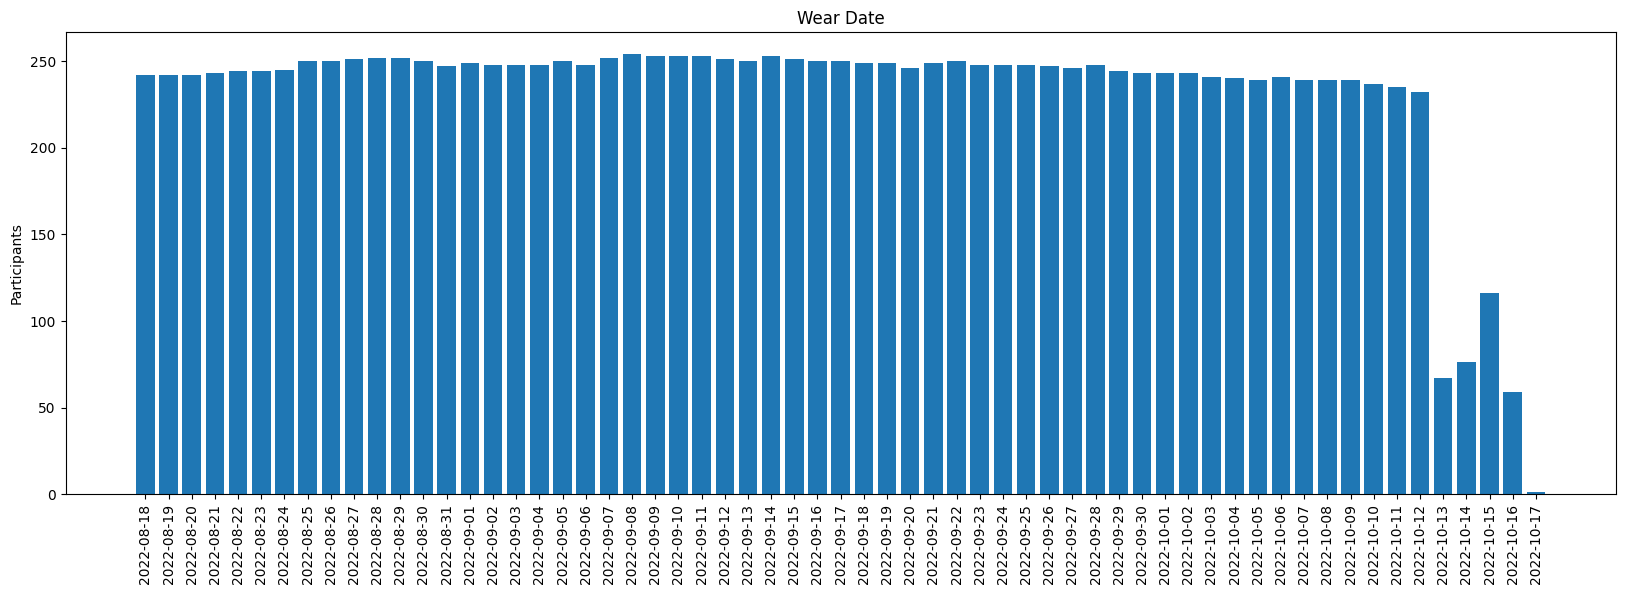

In [7]:
plt.figure(figsize=(20,6))
plt.bar(participants_wear_date.wear_date.to_list(), participants_wear_date.participants.to_list())
plt.xticks(rotation=90)
plt.title("Wear Date")
plt.ylabel("Participants")
plt.show()